# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Supervised learning: Regression problem </center>

## Table of contents  
  
1. [Метрики качества модели](#metrics)
2. [Пример: House Sales in King County, USA](#house_case)
3. [Обучающая и тестовая выборки](#train_test)
4. [Параметрические методы](#param)  
  4.1 [Линейная регрессия](#linreg) + [Регуляризации](#rgl)    
  4.2 [Полиномиальная регрессия](#polreg)  
5. [Задания](#tasks)

## Метрики качества модели <a name="metrics"></a>

В задачи регрессии в качестве метрик качества, как правило, используют различные функционалы ошибок - метрики, показывающие, насколько сильно ошибается модель при прогнозе.  
Метрики в питоне можно посмотреть [здесь](http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).

* __Среднеквадратичная ошибка (Mean Squared Error)__  
$$MSE = \frac{1}{n}\sum_{i=1}^{n}(a(x_{i}) - y_{i})^2$$

* __Корень среднеквадратичной ошибки (Root Mean Squared Error)__
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(a(x_{i}) - y_{i})^2}$$

* __Средняя абсолютная ошибка (Mean absolute error)__
$$MAE = \frac{1}{n}\sum_{i=1}^{n}\left |a(x_{i}) - y_{i}\right |$$

* __Медианная абсолютная ошибка (Median absolute error)__
$$MedAE = Q_{2}(\{\left |a(x_{i}) - y_{i}\right | : i = \overline{1, n}\}), $$ где $Q_{2}$ -  0.5-квантиль a.k.a медиана.

* __Коэффициент детерминации__  
Используется для сравнения модели $a(x)$ со средним значением целевой переменной по набору данных (__baseline__)
$$R^{2} = 1 - \frac{\sum_{i=1}^{n}(a(x) - y_{i})^{2}}{\sum_{i=1}^{n}(\overline{y} - y_{i})^{2}},$$ где $\overline{y}$ - среднее значение целевой переменной по наблюдаемым данным.

In [1]:
def calc_metrics(true, pred):
    mse = metrics.mean_squared_error(true, pred)

    rmse = np.sqrt(mse)

    mae = metrics.mean_absolute_error(true, pred)

    medae = metrics.median_absolute_error(true, pred)

    R2 = metrics.r2_score(true, pred)

    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse, rmse, R2, mae, medae))

## Пример: House Sales in King County, USA <a name="house_case"></a>

Будем пробовать различные методы, чтобы научиться определять цену на недвижимость.  
Данные взяты с [одноименного соревнования](https://www.kaggle.com/harlfoxem/housesalesprediction) на Kaggle.  

Данные содержат информацию о продажах индивидуальных домов в период с мая 2014 года по май 2015 в округе Кинг, штат Вашингтон, США.

In [2]:
import numpy as np
import pandas as pd

from sklearn import metrics

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# стиль seaborn
# style.available выводит все доступные стили
from matplotlib import style
style.use('seaborn')

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [3]:
house_data = pd.read_csv("kc_house_data.csv")

In [4]:
pd.set_option('display.max_columns', 25)

In [5]:
house_data.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [6]:
house_data.shape

(21613, 21)

In [7]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

### Признаки

In [8]:
# чобы текст в таблицах выводился польностью
pd.set_option('display.max_colwidth', None)  # use -1 instead of None for pandas older than 1.0

In [9]:
pd.read_csv('kc_house_features.csv', 
            delimiter=';', 
            encoding='windows-1251')

,Название признака,Описание
0,id,уникальный идентификационный номер проданного дома
1,date,дата продажи дома
2,bedrooms,количество спален
3,bathrooms,"количество ванных комнат (где 0.25 обозначает, что комната с туалетом, 0.5 – комната с туалетом и раковиной)"
4,sqft_living,общая площадь дома
5,sqft_lot,площадь прилегающей территории
6,floors,количество этажей
7,waterfront,"бинарный атрибут, указывающий на то, есть ли вид на реку или нет"
8,view,оценка внешнего вида дома (от 0 до 4)
9,condition,оценка состояния дома (от 0 до 5)


Оставим feature engineering на десерт, а пока просто удалим явным образом не подходящие признаки.

In [10]:
data = house_data.drop(['id', 'zipcode', 'date', 'sqft_living'], axis=1, inplace=False)

## Обучающая и тестовая выборки <a name="train_test"></a>

Для тестирования пока применим самый простой метод - разделим датасет на две части: на одной будем обучать, на другой оценивать качество модели.  
Различные способы тестирования и валидации доступны в модуле [sklearn.model_selection](http://scikit-learn.org/stable/modules/cross_validation.html).

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
(trainData, 
 testData, 
 trainDependentVariables, 
 testDependentVariables) = train_test_split(data.drop('price', axis=1),
                                            data['price'],
                                            test_size=0.3, 
                                            random_state=5)

In [13]:
trainData.shape

(15129, 16)

In [14]:
testData.shape

(6484, 16)

In [15]:
trainDependentVariables.shape

(15129,)

In [16]:
testDependentVariables.shape

(6484,)

## Параметрические методы <a name="param"></a>

## Линейная регрессия  <a name="linreg"></a>  
  
Документация [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [17]:
from sklearn import linear_model

In [18]:
%%time

regressionModel = linear_model.LinearRegression()
regressionModel.fit(trainData, trainDependentVariables)

Wall time: 62.8 ms


LinearRegression()

In [19]:
predictedDependentVariables = regressionModel.predict(testData)

In [20]:
predictedDependentVariables

array([ 427106.01601981,  151052.12538031,  487521.60220755, ...,
       1097778.39006299,  757510.88341913,  262667.02355159])

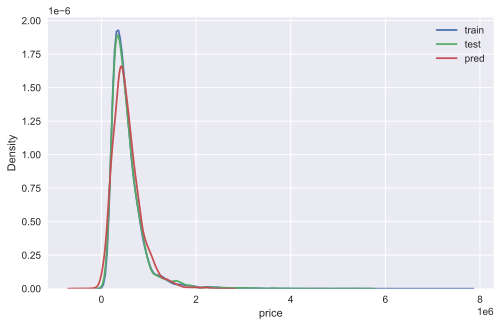

In [21]:
sns.kdeplot(trainDependentVariables, label='train')
sns.kdeplot(testDependentVariables, label='test')
sns.kdeplot(predictedDependentVariables, label='pred')
plt.legend()
plt.show()

### Ошибки на трейне

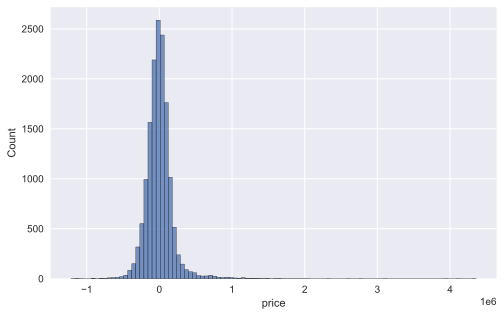

In [22]:
error = trainDependentVariables - regressionModel.predict(trainData)
sns.histplot(error, bins=100)
plt.show()

In [23]:
calc_metrics(trainDependentVariables, regressionModel.predict(trainData))

MSE:   41075702434.05568
RMSE:  202671.41494067604
R2:    0.6913708729653905
MAE:   125566.63577410726
MedAE: 88124.96491011977


### Ошибки на тесте

In [24]:
calc_metrics(testDependentVariables, predictedDependentVariables)

MSE:   41048712194.50817
RMSE:  202604.81779688303
R2:    0.7040174414788049
MAE:   126535.28858420804
MedAE: 88455.17611961067


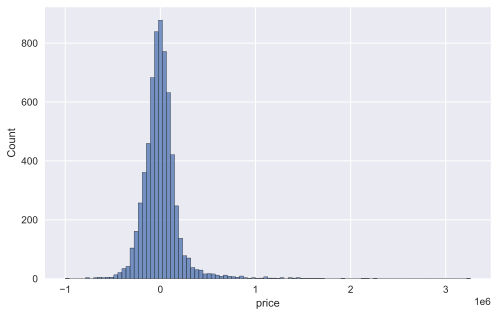

In [25]:
error = testDependentVariables - predictedDependentVariables
sns.histplot(error, bins=100)
plt.show()

In [26]:
coefs = pd.Series(regressionModel.coef_, 
                  index=trainData.columns)
coefs

bedrooms         -32516.214217
bathrooms         40394.986526
sqft_lot              0.130429
floors            -1095.621541
waterfront       558617.338902
view              50406.042891
condition         31383.764007
grade             98462.269651
sqft_above          178.443734
sqft_basement       144.262630
yr_built          -2452.664302
yr_renovated         24.514236
lat              563969.849473
long            -116822.529879
sqft_living15        24.479643
sqft_lot15           -0.383952
dtype: float64

In [27]:
x = abs(coefs).sort_values(ascending=False)
coefs[x.index]

lat              563969.849473
waterfront       558617.338902
long            -116822.529879
grade             98462.269651
view              50406.042891
bathrooms         40394.986526
bedrooms         -32516.214217
condition         31383.764007
yr_built          -2452.664302
floors            -1095.621541
sqft_above          178.443734
sqft_basement       144.262630
yr_renovated         24.514236
sqft_living15        24.479643
sqft_lot15           -0.383952
sqft_lot              0.130429
dtype: float64

In [28]:
regressionModel.intercept_

-36986702.437179744

In [29]:
trainDependentVariables.describe().apply(lambda x: '%.7f' % x)

count      15129.0000000
mean      538397.5363210
std       364828.1977766
min        80000.0000000
25%       322500.0000000
50%       450000.0000000
75%       642000.0000000
max      7700000.0000000
Name: price, dtype: object

In [30]:
trainData.describe()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,15129.000000,15129.000000,1.512900e+04,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.00000,15129.000000,15129.000000,15129.000000,15129.000000
mean,3.369357,2.113425,1.490791e+04,1.489656,0.007535,0.238350,3.411065,7.649944,1787.263996,290.556547,1970.761848,82.17212,47.559731,-122.214273,1980.653645,12741.324278
std,0.932691,0.770610,4.034152e+04,0.539100,0.086481,0.773132,0.650559,1.168060,826.459181,439.917335,29.368775,396.53545,0.138435,0.141451,680.322263,27192.330137
min,0.000000,0.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,380.000000,0.000000,1900.000000,0.00000,47.155900,-122.519000,460.000000,651.000000
25%,3.000000,1.500000,5.072000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.00000,47.471500,-122.329000,1480.000000,5102.000000
50%,3.000000,2.250000,7.615000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.00000,47.571400,-122.231000,1840.000000,7627.000000
75%,4.000000,2.500000,1.064600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1996.000000,0.00000,47.677500,-122.126000,2358.000000,10086.000000
max,33.000000,8.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.00000,47.777600,-121.315000,6210.000000,871200.000000


### Сделаем стандартизацию

Обучите модель линейной регрессии  
  1. на стандартизованных данных (параметр `normalize`)    
  2. без отступа $w_{0}$ (параметр `fit_intersept`)  
  
Оцените качество, сравните с предыдущей моделью.

## Регуляризации <a name="rgl"></a>

### Гребневая регрессия  
  
Документация [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

In [31]:
ridgeModel = linear_model.Ridge(alpha=0)

ridgeModel.fit(trainData, trainDependentVariables)

Ridge(alpha=0)

In [32]:
predictedDependentVariables = ridgeModel.predict(testData)

In [33]:
calc_metrics(testDependentVariables, predictedDependentVariables)

MSE:   41048712194.50853
RMSE:  202604.81779688393
R2:    0.7040174414788023
MAE:   126535.28858420296
MedAE: 88455.17612152547


In [34]:
coefs = pd.Series(ridgeModel.coef_, 
                  index=trainData.columns)

x = abs(coefs).sort_values(ascending=False)
coefs[x.index]

lat              563969.849473
waterfront       558617.338902
long            -116822.529879
grade             98462.269651
view              50406.042891
bathrooms         40394.986526
bedrooms         -32516.214217
condition         31383.764007
yr_built          -2452.664302
floors            -1095.621541
sqft_above          178.443734
sqft_basement       144.262630
yr_renovated         24.514236
sqft_living15        24.479643
sqft_lot15           -0.383952
sqft_lot              0.130429
dtype: float64

**Настройка значений гиперпараметра**

In [35]:
ridgeModel = linear_model.RidgeCV(alphas=np.arange(0, 30, 0.1), 
                                  cv=5, 
                                  scoring='neg_root_mean_squared_error')

In [36]:
%%time

ridgeModel.fit(trainData, trainDependentVariables)

Wall time: 27.3 s


RidgeCV(alphas=array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8...
       23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.1,
       24.2, 24.3, 24.4, 24.5, 24.6, 24.7, 24.8, 24.9, 25. , 25.1, 25.2,
       25.3, 25.4, 25.5, 25.6, 25.7, 25.8, 25.9, 26. , 26.1, 26.2, 26.3,
       26.4, 26.5, 26.6, 26.7, 26.8, 26.9, 27. , 27.1, 27.2, 27.3, 27.4,
       27.5, 27.6, 27.7, 27.8, 27.9, 28. , 28.1, 28.2, 28.3, 28.4, 28.5,
       28.6, 28.7, 28.8, 28.9, 29. , 29.1, 29.2, 29.3,

In [37]:
ridgeModel.alpha_

2.6

In [38]:
ridgeModel.best_score_ * -1

203217.7472177359

In [39]:
predictedDependentVariables = ridgeModel.predict(testData)

In [40]:
calc_metrics(testDependentVariables, predictedDependentVariables)

MSE:   41067072720.98941
RMSE:  202650.12391061944
R2:    0.703885052536176
MAE:   126516.26488044337
MedAE: 88260.73407836631


In [41]:
coefs = pd.Series(ridgeModel.coef_, 
                  index=trainData.columns)

x = abs(coefs).sort_values(ascending=False)
coefs[x.index]

lat              558275.349899
waterfront       543664.366501
long            -115665.268529
grade             98614.218823
view              50991.334522
bathrooms         40373.164103
bedrooms         -32628.449760
condition         31292.803561
yr_built          -2462.720307
floors             -792.579419
sqft_above          178.437392
sqft_basement       144.517037
yr_renovated         24.581140
sqft_living15        24.371200
sqft_lot15           -0.384770
sqft_lot              0.128477
dtype: float64

## Лассо регрессия  
  
Документация [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

In [42]:
lassoModel = linear_model.Lasso(alpha=0)

lassoModel.fit(trainData, trainDependentVariables)

<ipython-input-42-d57916f5433d>:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lassoModel.fit(trainData, trainDependentVariables)
C:\Users\k00503013\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\k00503013\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310717151062415.1, tolerance: 201353095897.24524
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0)

In [43]:
predictedDependentVariables = lassoModel.predict(testData)

In [44]:
calc_metrics(testDependentVariables, predictedDependentVariables)

MSE:   41048712194.50848
RMSE:  202604.81779688378
R2:    0.7040174414788027
MAE:   126535.28858420349
MedAE: 88455.17612151802


In [45]:
lassoModel = linear_model.LassoCV(alphas=np.arange(0.1, 10, 0.1), 
                                  normalize=True,
                                  cv=5)

In [46]:
%%time

lassoModel.fit(trainData, trainDependentVariables)

Wall time: 423 ms


LassoCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
        cv=5, normalize=True)

In [47]:
lassoModel.alpha_

2.0

In [48]:
predictedDependentVariables = lassoModel.predict(testData)

In [49]:
calc_metrics(testDependentVariables, predictedDependentVariables)

MSE:   41057789717.88907
RMSE:  202627.21860078193
R2:    0.7039519878152993
MAE:   126394.73944165959
MedAE: 88142.5091865547


In [50]:
coefs = pd.Series(lassoModel.coef_, 
                  index=trainData.columns)

x = abs(coefs).sort_values(ascending=False)
coefs[x.index]

lat              562633.065406
waterfront       556750.350630
long            -114657.351433
grade             98551.320593
view              50483.633733
bathrooms         39733.053325
bedrooms         -31719.349280
condition         31055.461820
yr_built          -2448.930014
sqft_above          177.517549
sqft_basement       144.025464
sqft_living15        24.319549
yr_renovated         24.093798
sqft_lot15           -0.347206
sqft_lot              0.107785
floors               -0.000000
dtype: float64

In [51]:
%%time

coefs = []
for alpha in np.arange(0, 1000, 1):
    lassoModel = linear_model.Lasso(alpha=alpha, normalize=True).fit(trainData, trainDependentVariables)
    coefs.append(abs(lassoModel.coef_))

coefs = pd.DataFrame(coefs, columns=trainData.columns)

<timed exec>:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\k00503013\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\k00503013\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310717151062413.4, tolerance: 201353095897.24524
  model = cd_fast.enet_coordinate_descent(


Wall time: 18.5 s


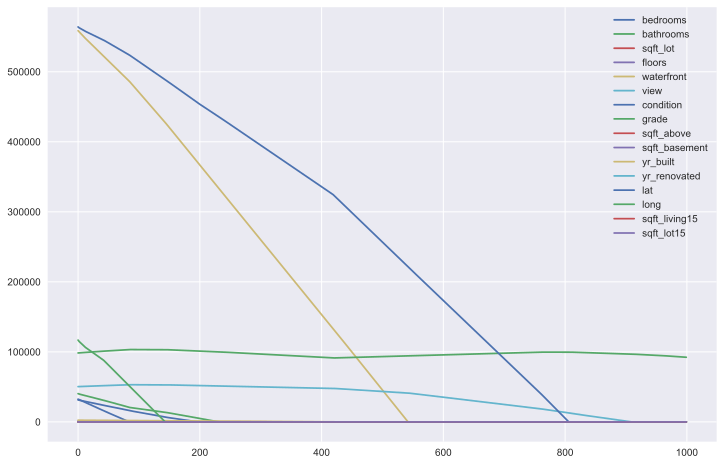

In [52]:
coefs.plot(figsize=(12, 8))
plt.show()

## ElasticNet

Objective function:  
$$\frac{1}{2N} \cdot ||y - \hat{y}||^2_2 + \alpha \cdot l1\_ratio \cdot ||w||_1 + 0.5 \cdot \alpha \cdot (1 - l1\_ratio) \cdot ||w||^2_2$$

**Задание:**  
* Обучите модель с дефолными параметрами  
* Подберите значения гиперпараметров модели на кросс-валидации с использованием `ElasticNetCV`.

## Полиномиальная регрессия <a name="polreg"></a>

In [53]:
from sklearn.preprocessing import PolynomialFeatures

### Линейная регрессия

In [54]:
poly = PolynomialFeatures(degree=1, include_bias=False)
poly.fit(trainData)

PolynomialFeatures(degree=1, include_bias=False)

In [55]:
poly_train = poly.transform(trainData)
poly_test = poly.transform(testData)

In [56]:
print('Original number of features:', trainData.shape[1])
print('Number of features after polynomial transformation:', poly_train.shape[1])

Original number of features: 16
Number of features after polynomial transformation: 16


In [57]:
%%time

regressionModel = linear_model.LinearRegression(normalize=True)
regressionModel.fit(poly_train, trainDependentVariables)

Wall time: 14 ms


LinearRegression(normalize=True)

Значения совпадают с результатами для линейной модели.

In [58]:
# Train
calc_metrics(trainDependentVariables, regressionModel.predict(poly_train))

MSE:   41075702434.05568
RMSE:  202671.41494067604
R2:    0.6913708729653905
MAE:   125566.63577410574
MedAE: 88124.96490994096


In [59]:
# Test
calc_metrics(testDependentVariables, regressionModel.predict(poly_test))

MSE:   41048712194.50898
RMSE:  202604.81779688504
R2:    0.7040174414787991
MAE:   126535.28858420067
MedAE: 88455.1761215739


### Квадратичная регрессия

$$ a(x_1, x_2) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1^2 + w_4 x_{1} x_{2} + w_5 x_2^2$$

In [60]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(trainData)

poly_train = poly.transform(trainData)
poly_test = poly.transform(testData)

print('Original number of features:', trainData.shape[1])
print('Number of features after polynomial transformation:', poly_train.shape[1])

Original number of features: 16
Number of features after polynomial transformation: 152


In [61]:
%%time

regressionModel = linear_model.LinearRegression(normalize=True)
regressionModel.fit(poly_train, trainDependentVariables)

Wall time: 142 ms


LinearRegression(normalize=True)

Стало заметно лучше по сравнению с линейной моделью.

In [62]:
print('Train:')
calc_metrics(trainDependentVariables, regressionModel.predict(poly_train))

print('\nTest:')
calc_metrics(testDependentVariables, regressionModel.predict(poly_test))

Train:
MSE:   24261966293.117264
RMSE:  155762.53173699143
R2:    0.8177036780026024
MAE:   100283.26862172782
MedAE: 70247.65871191025

Test:
MSE:   27668779356.06759
RMSE:  166339.34999292137
R2:    0.8004937142446343
MAE:   105443.91911051849
MedAE: 71558.64393806458


### Регрессия полиномом 3-й степени

In [63]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit(trainData)

poly_train = poly.transform(trainData)
poly_test = poly.transform(testData)

print('Original number of features:', trainData.shape[1])
print('Number of features after polynomial transformation:', poly_train.shape[1])

Original number of features: 16
Number of features after polynomial transformation: 968


In [64]:
%%time

regressionModel = linear_model.LinearRegression(normalize=True)
regressionModel.fit(poly_train, trainDependentVariables)

Wall time: 1.55 s


LinearRegression(normalize=True)

Все очень плохо - модель переобучилась

In [65]:
print('Train:')
calc_metrics(trainDependentVariables, regressionModel.predict(poly_train))

print('\nTest:')
calc_metrics(testDependentVariables, regressionModel.predict(poly_test))

Train:
MSE:   14179752149.38655
RMSE:  119078.76447707438
R2:    0.8934580720936389
MAE:   78318.68012017224
MedAE: 53710.4404296875

Test:
MSE:   456160543793.14
RMSE:  675396.5826039839
R2:    -2.2891547049891794
MAE:   123391.51747842044
MedAE: 59989.763671875


In [66]:
error = abs(testDependentVariables - regressionModel.predict(poly_test))
np.quantile(error, np.arange(0, 1.01, 0.1))

array([8.21289062e-01, 1.05317633e+04, 2.15814920e+04, 3.40172260e+04,
       4.61947932e+04, 5.99897637e+04, 7.66770693e+04, 9.96486025e+04,
       1.35435203e+05, 2.10063274e+05, 4.32111824e+07])

Это можно поправить регуляризацией

In [67]:
%%time

regressionModel = linear_model.Ridge(alpha=0.01, normalize=True)
regressionModel.fit(poly_train, trainDependentVariables)

Wall time: 674 ms


Ridge(alpha=0.01, normalize=True)

In [68]:
print('Train:')
calc_metrics(trainDependentVariables, regressionModel.predict(poly_train))

print('\nTest:')
calc_metrics(testDependentVariables, regressionModel.predict(poly_test))

Train:
MSE:   26683654225.863823
RMSE:  163351.3214695976
R2:    0.7995079226449496
MAE:   105128.52551045554
MedAE: 72642.13658134639

Test:
MSE:   31919994957.83478
RMSE:  178661.67736208788
R2:    0.7698402393031082
MAE:   110663.12924812235
MedAE: 74357.08576981258


## Задания: <a name="tasks"></a>  
  
1. Оцените качество линейной и полиномиальной моделей на KFold валидации (используйте 5 фолдов). Насколько отличается качество на различных фолдах?  
Ниже в заданиях также используйте KFold валидацию.  
2. Обучите полиномиальную регрессию на данных, стандартизованных с помощью `StandardScaler()`. Попробуйте степени полинома 1, 2 и 3, не забывайте про регуляризацию. Сравните результаты с [обычной нормализацией](#polreg).  
3. Выполните преобразования данных, рассмотренные в файле `Regression.Part1.ipynb`, и обучите на преобразованных данных линейную регрессию. Оцените, есть ли всмысл в применении регуляризации. В любом случае, обучите линейную регрессию с регуляризацией (Ridge или Lasso), сравните с результатами без регуляризации.  
4. Обучите полиномиальную регрессию на преобразованых данных. Насколько точнее стала модель?